In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from detect_staircases import classify_staircase 
plt.rcParams.update({'font.size': 16})

# Thermohaline classifier demo

This notebook demonstrates the functionality of the staircase classification algorithm

### Test classifier with synthetic data

First we create synthetic profiles of temperature and salinity data to check that the classifier works on idealised data. This is similar to the [internal software test](https://github.com/callumrollo/thermohaline-steps/blob/main/test_staircase.py) used in development

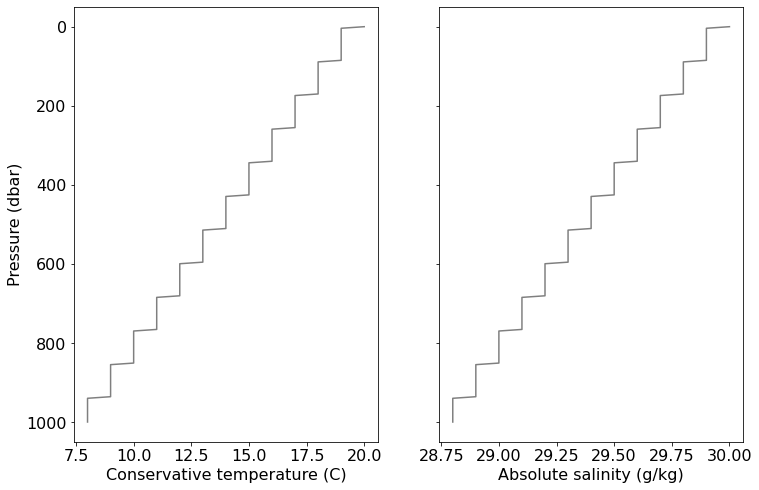

In [2]:
p_in = np.arange(1000)
ct_in = np.empty(len(p_in))
sa_in = np.empty(len(p_in))

diff_c = -1
diff_s = -0.1
mix = 80
interface = 5
current_c = 20
current_s = 30
for start in np.arange(0, 1000, mix+interface):
    ct_in[start: start + interface] = np.linspace(current_c, current_c + diff_c, interface)
    current_c +=diff_c
    ct_in[start + interface: start + interface + mix] = current_c
    sa_in[start: start + interface] = np.linspace(current_s, current_s + diff_s, interface)
    current_s +=diff_s
    sa_in[start + interface: start + interface + mix] = current_s  

fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
ax = ax.ravel()
ax[0].plot(ct_in, p_in, color="k", alpha=0.5)
ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
ax[1].plot(sa_in, p_in, color="k", alpha=0.5)
ax[1].set(xlabel="Absolute salinity (g/kg)")
ax[0].invert_yaxis()

df, mixes, grads = classify_staircase(p_in, ct_in, sa_in)

Next we run the classifier on this synthetic data and plot the results

In [3]:
df, mixes, grads = classify_staircase(p_in, ct_in, sa_in)

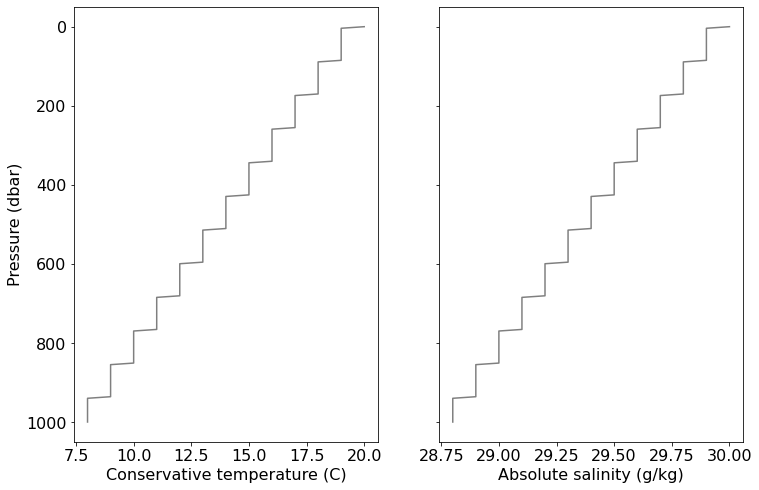

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
ax = ax.ravel()
ax[0].plot(ct_in, p_in, color="k", alpha=0.5)
ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
ax[1].plot(sa_in, p_in, color="k", alpha=0.5)
ax[1].set(xlabel="Absolute salinity (g/kg)")
ax[0].invert_yaxis()

# Classifier on Argo data

Here we use Argo data from the Meditteranean to test the classifier against a real world example. We have made small adjustments to the kwargs to 

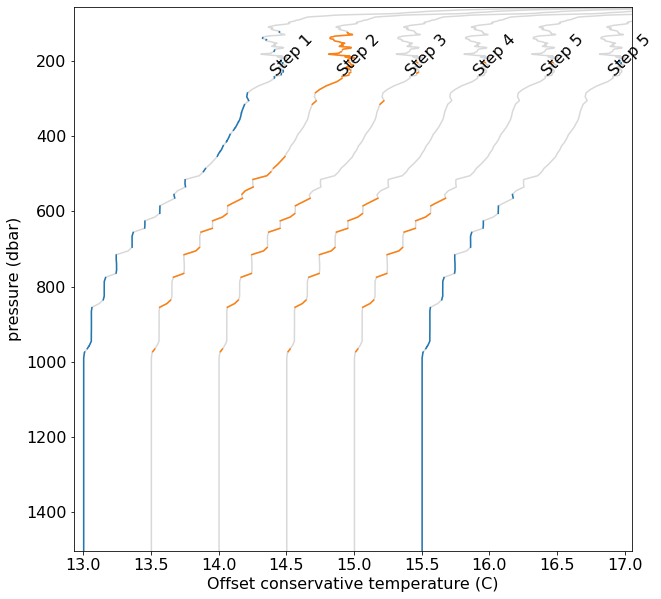

In [5]:
df_in = pd.read_csv('data/vanderboog_argo_demo_data.csv')
df_out, mixes, grads = classify_staircase(df_in.pressure, df_in.conservative_temperature, df_in.absolute_salinity,
                                          temp_flag_only=True, show_steps=True, layer_height_ratio=0.95, ml_grad=0.00048)


### Help on the classifier

By calling `help()` on the classifier, we can view the docstring and see definitions of the variables that must be passed to it, and what the classifier kwargs are

In [6]:
help(classify_staircase)

Help on function classify_staircase in module detect_staircases:

classify_staircase(p, ct, sa, ml_grad=0.0005, ml_density_difference=0.005, av_window=200, interface_max_height=30, layer_height_ratio=1, temp_flag_only=False, show_steps=False)
    all data should be at 1 dbar resolution (for now)
    Notes:
    - Currently dropping min and max pressure values, so can have Turner angle at all points
    - Turner angle and stability-ratio from smoothed profile
    :param show_steps: if True, creates and shows a plot of filtering steps, default: False
    :param p: pressure (dbar)
    :param ct: conservative temperature (degrees celsius)
    :param sa: absolute salinity (g kg-1)
    :param ml_grad: density gradient for detection of mixed layer (kg m^-3 dbar^-1), default: 0.0005
    :param ml_density_difference: maximum density gradient difference of mixed layer (kg m^-3), default: 0.005
    :param av_window: averaging window to obtain background profiles (dbar), default: 200
    :param int